In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

1.13.1+cu116


Extracting data\GeometricShapes\raw.zip
Processing...


GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


Done!
C:\Users\lllang\AppData\Local\Temp\ipykernel_19752\2548866971.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


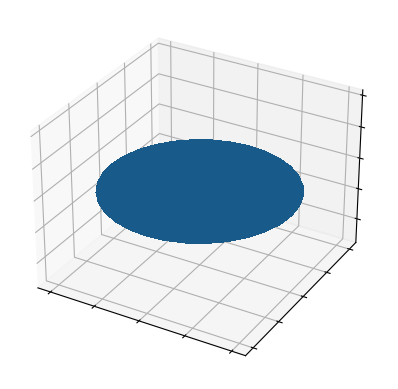

Data(pos=[4, 3], face=[3, 2], y=[1])


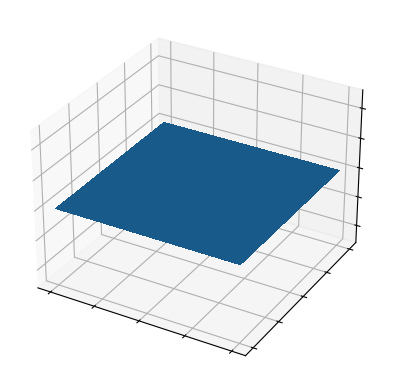

In [3]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

Data(pos=[256, 3], y=[1])


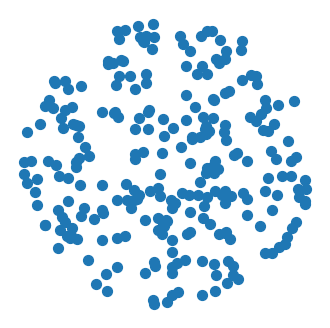

Data(pos=[256, 3], y=[1])


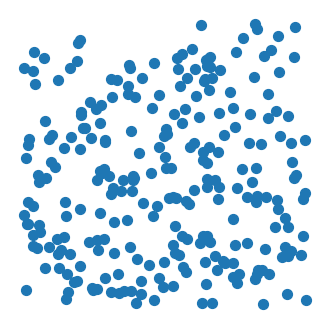

In [4]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)

torch.Size([2, 1536])


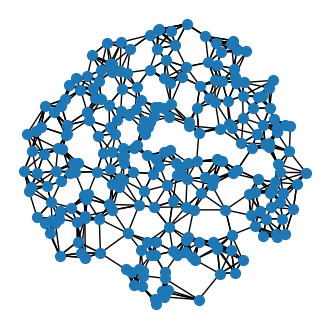

torch.Size([2, 1536])


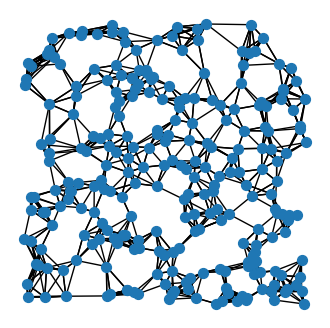

In [5]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[4]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

In [6]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [7]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [8]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader

train_dataset = GeometricShapes(root='data/GeometricShapes', train=True,
                                transform=SamplePoints(128))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128))


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 3.7549, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.7011, Test Accuracy: 0.0250
Epoch: 03, Loss: 3.6830, Test Accuracy: 0.0250
Epoch: 04, Loss: 3.6705, Test Accuracy: 0.0250
Epoch: 05, Loss: 3.6338, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.5937, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.5599, Test Accuracy: 0.0250
Epoch: 08, Loss: 3.4820, Test Accuracy: 0.0500
Epoch: 09, Loss: 3.4096, Test Accuracy: 0.0500
Epoch: 10, Loss: 3.3637, Test Accuracy: 0.0500
Epoch: 11, Loss: 3.2883, Test Accuracy: 0.0750
Epoch: 12, Loss: 3.2181, Test Accuracy: 0.1000
Epoch: 13, Loss: 3.1262, Test Accuracy: 0.1500
Epoch: 14, Loss: 3.0487, Test Accuracy: 0.1750
Epoch: 15, Loss: 2.9215, Test Accuracy: 0.1750
Epoch: 16, Loss: 2.8044, Test Accuracy: 0.2000
Epoch: 17, Loss: 2.6913, Test Accuracy: 0.3500
Epoch: 18, Loss: 2.5293, Test Accuracy: 0.2750
Epoch: 19, Loss: 2.4080, Test Accuracy: 0.4250
Epoch: 20, Loss: 2.1689, Test Accuracy: 0.2750
Epoch: 21, Loss: 2.1438, Test Accuracy: 0.4000
Epoch: 22, Lo

40
Data(pos=[32, 3], face=[3, 30], y=[1])


C:\Users\lllang\AppData\Local\Temp\ipykernel_19752\2548866971.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


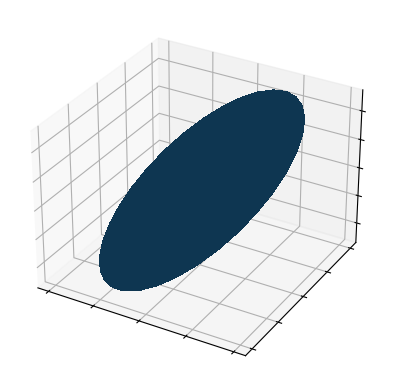

Data(pos=[4, 3], face=[3, 2], y=[1])


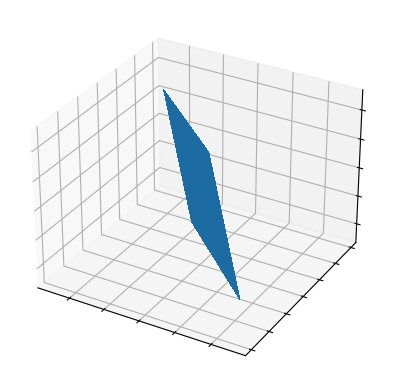

In [11]:
from torch_geometric.transforms import Compose, RandomRotate

torch.manual_seed(123)

random_rotate = Compose([
    RandomRotate(degrees=180, axis=0),
    RandomRotate(degrees=180, axis=1),
    RandomRotate(degrees=180, axis=2),
])

dataset = GeometricShapes(root='data/GeometricShapes', transform=random_rotate)

print(dataset.num_classes)
data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

In [10]:
torch.manual_seed(42)

transform = Compose([
    random_rotate,
    SamplePoints(num=128),
])

test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=transform)

test_loader = DataLoader(test_dataset, batch_size=10)

test_acc = test(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2000
